# Data Science Problem Set 1: 
## Signal Processing and Data Visualization of a LIGO Binary Black Hole Merger

Josh Dillon

Based on [LIGO Open Science Center tutorials](https://www.gw-openscience.org/tutorials/). 

In 2015, the [Laser Interferometer Gravitational-Wave Observatory (LIGO)](https://en.wikipedia.org/wiki/LIGO) made the [first direction detection](https://en.wikipedia.org/wiki/First_observation_of_gravitational_waves) of gravitational waves---waves in the fabric of spacetime itself propagating at the speed of light. What they saw was the result of two black holes, each roughly 30 times the mass of the sun approximately 400 Mpc (1.3 billion light years) away. That event was so violent that approximately 3 solar masses were converted into energy (via $E = mc^2$) and released as gravitational radiation. 

![](data/BBH.gif)
**Figure: Binary black holes inspiraling radiate away energy as gravitational radiation. Credit: [LIGO Caltech](https://www.ligo.caltech.edu/page/ligos-ifo)**


These were detected by two laser interferometers, one in Hanford, Washington and the other in Livingston, Louisiana.

![](data/Hanford.jpg)

**Figure: Each LIGO detector featues two 4 km arms (LIGO Hanford shown here. Credit: [LIGO Caltech](https://www.ligo.caltech.edu/page/ligos-ifo)**

This discovery was recognized with many awards, including the 2017 Nobel Prize in Physics.

The purpose of this problem set is to explore topics in data visualization (and sonification) and signal processing using data from that event, known as GW150914 (since it occurred on September 14, 2015).

In [30]:
import numpy as np
import scipy
from scipy import signal

from matplotlib import pyplot as plt
%matplotlib notebook

## Load the data:

I've already downloaded the relevant data and saved it to a npz file with everything you need. 

In [3]:
data = np.load('data/ligo_data.npz')
times = data['times'] # Times in seconds since the gravitational wave event. 
hanford_strain = data['hanford_strain'] # Strain amplitude measured at LIGO Hanford, unitless
livingston_strain = data['livingston_strain'] # Strain amplitude measured at LIGO Livingston, unitless

## Problem 1: Plotting Gravitational Wave Strain

Gravitational waves can be thought of as a stretching and squeezing of spacetime. This is usually described by a **strain**, $h$, which is the fractional change in length as a gravitational wave passes by. 

$h = \Delta L / L$

Here's an example of what a ring of "stationary" particles look like as a gravitational wave passes for a strain of $h = .5$. 



<a href=https://en.wikipedia.org/wiki/Gravitational_wave> <img src="data/strain.gif" /> </a>

You can think of LIGO as sitting at the center of this ring, with mirrors at 12 o'clock and 3 o'clock. LIGO is designed to measure the difference of the lengths of the two arms very precisely as a fuction of time.

<a href=https://www.ligo.caltech.edu/page/ligos-ifo> <img src="data/ligo_layout.jpg" style="width:600px;"/> </a>

However, instead of strains of order 1, LIGO is looking for is looking for strains $h \lesssim 10^{-21}$. 

### Plot the strain amplitudes measured at the two detectors as a function of time. Don't forget to label your axes and include a legend.

<IPython.core.display.Javascript object>


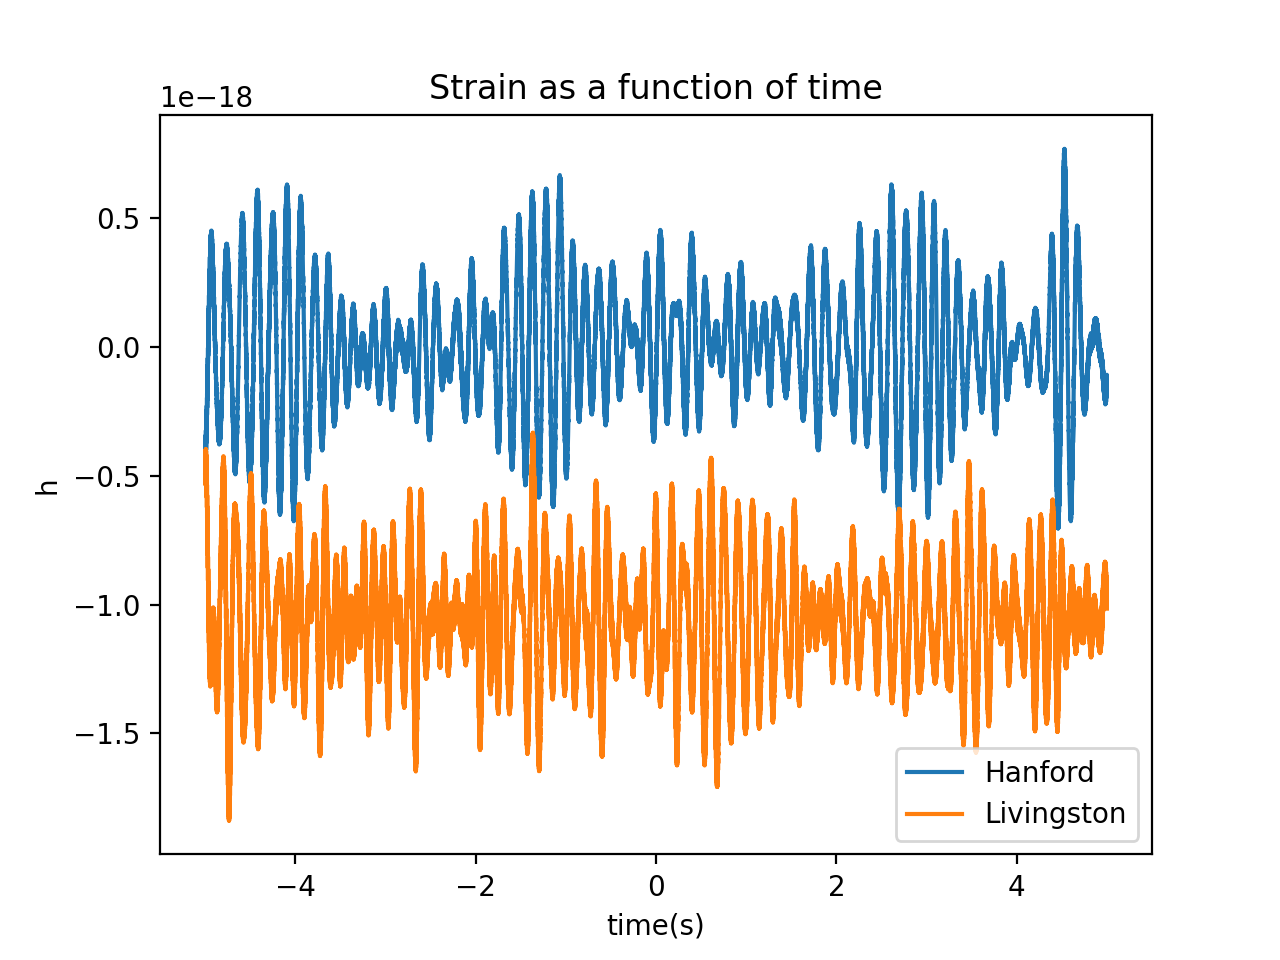

Text(0.5, 1.0, 'Strain as a function of time')

In [9]:
plt.plot(times, hanford_strain, label = "Hanford")
plt.plot(times, livingston_strain, label = "Livingston")
plt.legend()
plt.xlabel("time(s)")
plt.ylabel("h")
plt.title("Strain as a function of time")

## Problem 2: Looking at the Amplitude Strain Density

You should see that both detectors measured a complicated signal with content at many different frequencies. However, most of that is not the gravitational wave signal. What you're seeing is various sources of noise in the measurement. To understand better the systematics, it is useful to look at the Fourier transform of the signal. 

The traditional way of doing this in gravitational wave physics is is to look at a quantity called the "Amplitude Strain Density" which is a basically the square root of the power spectrum. There are several ways of estimating the spectral content of a signal using a [periodogram](https://en.wikipedia.org/wiki/Periodogram). One useful one, [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) is built into `scipy.signal`, which breaks the signal up into chunks, computes the power, and then averages that together.

<IPython.core.display.Javascript object>


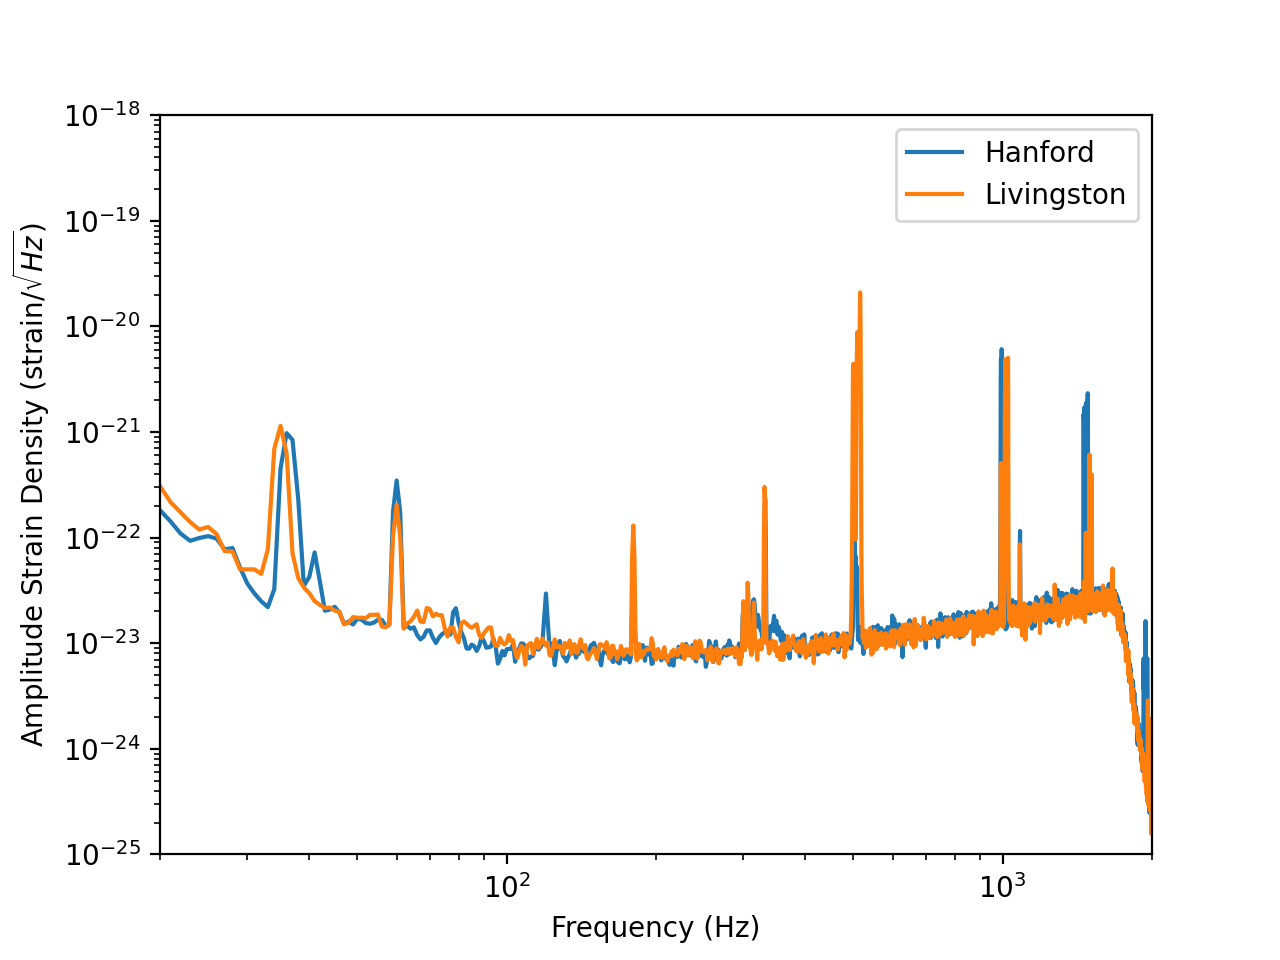

In [23]:
delta_t = (times[1] - times[0])
sampling_freq = delta_t**-1

# this treats each second as a different "segment" or chunk, though you can play around with different nperseg
freqs, power_hanford = scipy.signal.welch(hanford_strain, sampling_freq, nperseg=1*sampling_freq, detrend=False)
freqs, power_livingston = scipy.signal.welch(livingston_strain, sampling_freq, nperseg=1*sampling_freq, detrend=False)

# These interpolators will be useful later.
from scipy.interpolate import interp1d
hanford_power_interpolator = interp1d(freqs, power_hanford)
livingston_power_interpolator = interp1d(freqs, power_livingston)

plt.figure()
# Note we're taking the square root, since we want something that's directly proportional to the strain amplitude.
# If you double the strain, the power quadruples.
plt.loglog(freqs, np.sqrt(power_hanford), label='Hanford') 
plt.loglog(freqs, np.sqrt(power_livingston), label='Livingston')
# plt.loglog(freqs, np.sqrt(noise_power_model(freqs)), 'k--', label='Noise Power Model')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Strain Density (strain/$\sqrt{Hz}$)')
plt.xlim(20, 2000)
plt.ylim([1e-25, 1e-18])
plt.legend()

This produces "cleaner" results than simply taking a Fourier transform without any fancy chunking or averaging, but it's still useful to explore that method to get a sense of what's going on.

### Plot the Amplitude Strain Density by taking a simple FFT using `np.fft.fft`:

***Hints: you'll probably need to multiply by a [window function](https://en.wikipedia.org/wiki/Window_function) like a Blackman-Harris to get sensible results. That window function should be normalized to 1 so as to not lose power. Think about how to properly normalize the FFT to have sensible physical units; you're approximating an integral over time by a sum, so you'll have to think about how the length element $dt$ is accounted for. Also, check out how [`np.fft.fft` is normalized here](https://numpy.org/doc/stable/reference/routines.fft.html#normalization).***

<IPython.core.display.Javascript object>


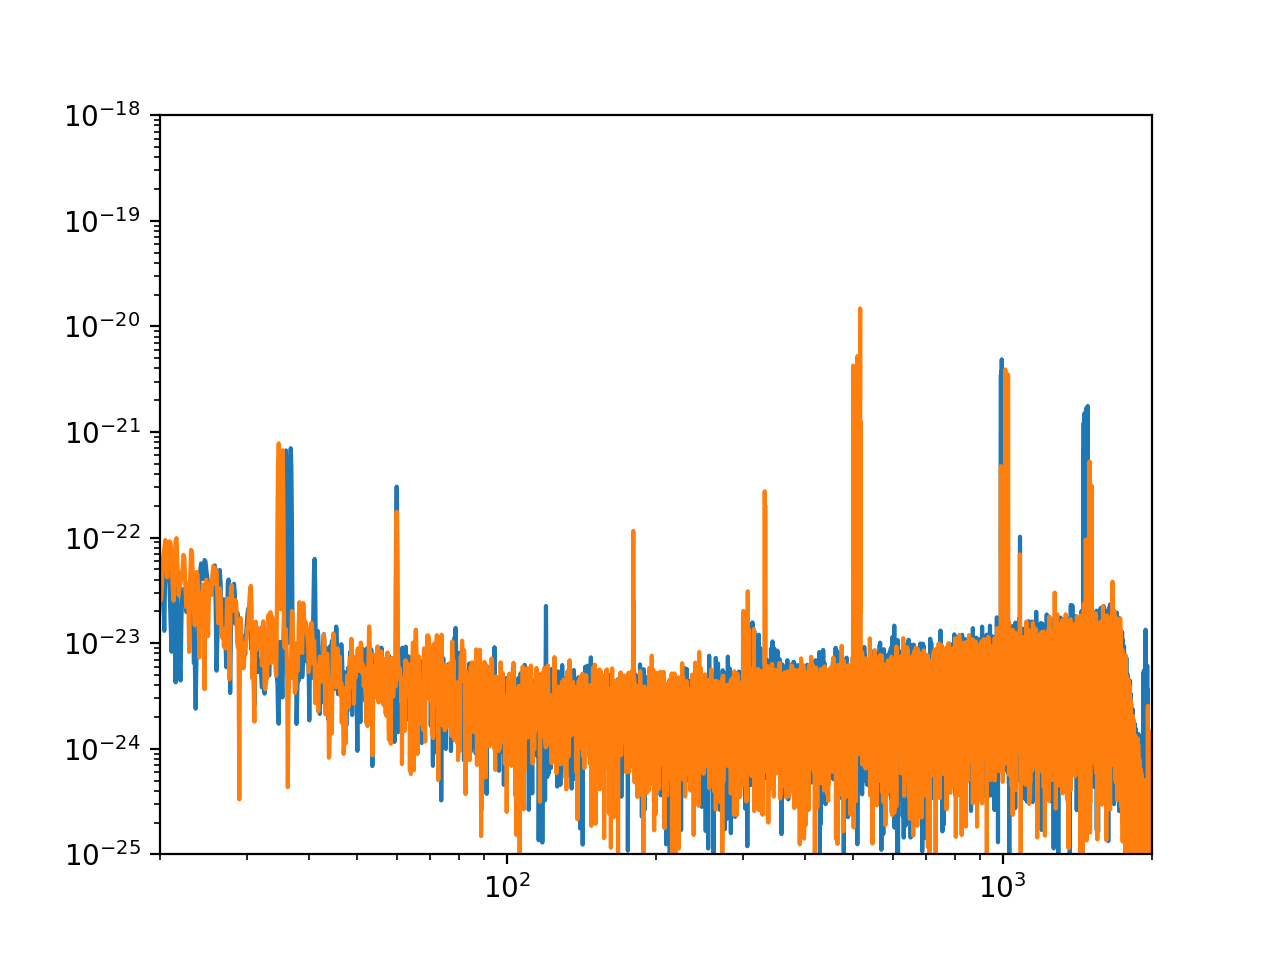

(1e-25, 1e-18)

In [110]:
window = signal.windows.blackmanharris(len(hanford_strain))
fh = np.fft.fft(window * hanford_strain, norm = "forward") /np.mean(window)
fl = np.fft.fft(window * livingston_strain, norm = "forward") /np.mean(window)
afh = np.abs(fh)
afl = np.abs(fl)
freq = np.linspace(0, 1/delta_t, len(hanford_strain))
plt.loglog(freq, afh)
plt.loglog(freq, afl)
plt.xlim(20, 2000)
plt.ylim([1e-25, 1e-18])

# Problem 3: Interlude: Colored Noise, Whitening, and Sonification

An important feature of the different sources of noise in the LIGO data is that it is they have different amounts of power at different frequencies. That would be "white noise." Noise with more high frequency power, in analogy with visible light, is "blue noise." Noise with more low frequency power is "red noise." We can simulate noise like that by taking white noise, which is just uncorrelated Gaussian random noise generated with `np.random.randn`, Fourier transforming it, modifying the amplitude in a frequency-dependent way, and the Fourier transforming back. For example, we use the following function to generate some white, red, and blue noise.

In [ ]:
def colored_noise(times, exponent, min_freq=20):
    '''Creates random noise with a spectrum proportional to freq^exponent.'''
    white_noise = np.random.randn(len(times))
    freqs = np.fft.rfftfreq(len(times), times[1] - times[0]) #rfft is useful when the input signal is real
    noise = np.fft.rfft(white_noise)
    noise[np.abs(freqs) >= min_freq] *= np.abs(freqs[np.abs(freqs) >= min_freq])**exponent
    # Remove power below where you can hear it, avoids division by 0
    noise[np.abs(freqs) < min_freq] = 0 
    noise = np.fft.irfft(noise)
    # Renormalize the noise so it has the same power as white noise
    noise /= np.std(noise) 
    return noise

white_noise = colored_noise(times, 0)
blue_noise = colored_noise(times, 1)
red_noise = colored_noise(times, -1)

### Problem 3a: Use `scipy.signal.welch` to plot the amplitude spectral density of white, blue, and red noise, just as we did above with LIGO data.

In [ ]:
# your code here


One way of understanding timestreams like these is to transform them into sound. Sound is just pressure waves in the air. What you hear can be expressed as an amplitude as a function of time, which is precisely what a `.wav` file includes. While LIGO doesn't measure sound waves, the frequencies it "listens" are in the audible range (roughly 20 Hz to 20 kHz, though the top end generally gets lower as you get older). So for example, we can use the following function to play data vectors, be they simulated noise or LIGO signal, as sound. So turn your sound on and see if you can hear the difference!

In [ ]:
def play_audio(data, times, t_start=None, t_end=None):
    '''Convert data to a wav file and play it in the notebook, given times in s.'''
    from IPython.display import Audio
    from scipy.io import wavfile
    sampling_freq = (times[1] - times[0])**-1
    if t_start is None:
        t_start = times[0]
    if t_end is None:
        t_end = times[-1]
    d = data[(times >= t_start) & (times <= t_end)]
    # renornmalize the data so that it uses the dynamic range of a 32-bit wav file
    d = np.int32(d / np.max(np.abs(d)) * 2147483647 * 0.99)
    wavfile.write('temp.wav', int(sampling_freq), d)
    return Audio('temp.wav', autoplay=True)

In [ ]:
play_audio(white_noise, times, t_start=-2.5, t_end=2.5)

In [ ]:
play_audio(blue_noise, times, t_start=-2.5, t_end=2.5)

In [ ]:
play_audio(red_noise, times, t_start=-2.5, t_end=2.5)

In signal processing we can use our knowledge the about the statistical properties of the noise to upweight the modes with more signal relative to the noise. In some cases, this is a simple as dividing out by the noise amplitude spectrum in Fourier space. This is the basic idea behind the [Wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) and many more sophisticated techniques. Our goal today is just to get some intuition for this using sonification. Let's pretend for a moment that the following is our "signal":

In [ ]:
from scipy.io import wavfile
sampling_rate, song = wavfile.read('data/beatles.wav')
song = song / np.max(np.abs(song))
ts = np.arange(len(song)) / sampling_rate
play_audio(song, ts)

Now let's add some white noise, some very strong blue noise, and listen again.

In [ ]:
blue_noise = colored_noise(ts, 4)
white_noise = colored_noise(ts, 0, min_freq=0)
# Add very strong, very blue noise to dominate the high frequencies
noise = 100 * blue_noise + white_noise
noisy_song = 5 * song + noise
play_audio(noisy_song, ts)

The signal is still there, but it's swamped by the noise--just like in LIGO. But if we use the following function to whiten the data given the power spectrum of the noise, we can start teasing out the signal from the noise. 

In [ ]:
def whiten(data, times, noise_power_spectrum_func):
    '''Use a function that returns power spectra as a function of frequency
    (either interpolated or analytic) to whiten the noise in the data.'''
    fft_data = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(len(data), d=(times[1] - times[0]))
    fft_data /= np.sqrt(noise_power_spectrum_func(freqs))
    return np.fft.irfft(fft_data * 1./np.sqrt(1./((times[1] - times[0]*2))))

In [ ]:
# calculate new sampling frequency for this audio clip
fs = (ts[1] - ts[0])**-1
# calculate power spectrum of the song with noise and just the noise
freqs, power_noisy_song = scipy.signal.welch(noisy_song, fs, nperseg=fs, detrend=False)
freqs, power_noise = scipy.signal.welch(noise, fs, nperseg=fs, detrend=False)
# get an interpolated noise power spectrum
noise_power_interpolator = interp1d(freqs, power_noise)

### Problem 3c: Plot the amplitude spectral density of the the noise, the song clip with the noise, and of the whitened noise. 

In [ ]:
# Your code here


It's still not perfect, but hopefully that sounds _a lot_ better than with the raw noise!

And now, back to LIGO...

# Problem 4: Now let's look at how the LIGO spectrum evolves in time.

As we said before, the vast majority of what we see in the spectrum is not the gravitational wave signal. That signal occupies a small fraction of the times and frequencies, so in order to see that we want to further break up the spectrum into different time bins, producing a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram). This is a bit of a funny operation, since it's turning a 1D time series into a 2D plot. This is a achieved by breaking the data into blocks of size `NFFT`, taking the Fast Fourier Transform, then moving on to the next chunk. The larger the chunk, the better the frequency resolution, but the worse the temporal resolution. If this sounds familiar, it's because it's essentially a sort of [uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle#Signal_processing).

Better temporal resolution can be achieved by letting subsequent blocks overlap, though this introduces correlations between neighboring times. This makes plots a bit easier to read, but doesn't fundamentally change the information content.

Let's start with a simplified example, where we have a sinusoidal signal $sin(\omega t)$ whose angular frequency (in radians per second) is given by 

$\omega = 2 \pi \times 4 \left(\frac{t}{1 s}\right)^2 $.

Here we show what this signal looks like in time and as a spectrogram.

In [ ]:
spectrogram_interval = 1 / 8 # seconds
NFFT = int(spectrogram_interval / delta_t)
noverlap = int(NFFT*63./64) # the closer this value is to NFFT, the higher time resolution, but the more correlated the points are
window = np.blackman(NFFT)

fig, axes = plt.subplots(1, 2, figsize=(10,6))
omega = 4.0 * (times / 1)**2
variable_tone = np.sin(times * omega * 2 * np.pi)
axes[0].plot(times, variable_tone, lw=.25)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (Unitless)')

# note: ax.specgram returns 4 arguments, the last of which is the image data needed for the colorbar
_, _, _, im = axes[1].specgram(variable_tone, NFFT=NFFT, Fs=sampling_freq, window=window,
                               noverlap=noverlap, xextent=[times[0], times[-1]], cmap='inferno')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
plt.colorbar(im, ax=axes[1])
plt.tight_layout()

The spectrogram allows us to clearly see the frequency's quadratic time dependence. Try playing around with `spectrogram_interval`, `noverlap`, and the `window` to see how they affect the spectrogram. 

### Your turn. Plot a spectrogram of the strain at both Hanford and Livingston using `plt.specgram`. 
**Hint: You should see lots of noise at all frequencies (just as in the power spectrum), as well as horizontal lines corresponding to the spikes in the power spectrum (these are resonances in the suspension system of the LIGO mirrors). Do you see anything interesting at t$\approx$0 if you zoom in?**

In [ ]:
# your code here


## Problem 5: Looking for the gravitational wave chirp

Now let's put together what we've learned about whitening and spectrograms to plot the gravitational wave signal as cleanly as possible.

### Use the interpolated powers from Problem 1, the whitening function from Problem 3, and the `specgram` method you employed above to show the strain for both Hanford and Livingston as a function of time and frequency.
**Hint: use `ax.set_ylim` and `ax.set_xlim` to zoom in on the signal at t$\approx$0 and the frequency range where the signal is detectable over the noise.**

In [ ]:
# your code here


You should see a "chirp", a signal that's rising in frequency. *That's the signal!* The frequency is set by the orbital period of the two black holes, which emitting energy in the form of gravitational waves. As they lose energy, their orbit decays or "inspirals," increasing the orbital frequency until they merge.

(The reason the whitening method worked so well here is because the power spectra we computed in Problem 1 include many time samples with just noise and only a few times with signal in them. So they are good estimates of the background noise-only, including the bright resonant lines from vibrational modes in the detector.)

## Problem 6: Filtering and plotting the gravitational wave signal.

The spectrogram above has the virtue of showing us different frequencies separately. But if we just want to see the waveform itself, our best bet is not just to whiten, but actually filter off the frequencies we know are just noise. Filtering is a deep topic in signal processing, but the absolute simplest frequency filter is simply to Fourier transform, set some frequencies to 0, and then Fourier transform back. This isn't ideal for many applications, but it'll do for our purposes.

In [ ]:
def bandpass_filter(data, times, fmin=0, fmax=np.inf):
    '''This simple filter zeros-out fourier content in the data
    outside of the the frequency range fmin to fmax.'''
    fft_data = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(len(data), d=(times[1] - times[0]))
    fft_data[np.abs(freqs) < fmin] = 0
    fft_data[np.abs(freqs) > fmax] = 0
    return np.fft.irfft(fft_data)

### Plot the whitened and filtered gravitational wave strain as a function of time for both Hanford and Livingston, zooming in on the chirp.
**Hints: You'll notice that the filter makes the strain go wild at at the beginning and end of the interval. There are lots of ways of combating this effect, like using window functions, but for now it's not necessary since the signal is at t$\approx$0. Also, don't worry about the units on the y-axis; we could work them out with a more careful whitening, but that's beyond the scope for this exercise.**

In [ ]:
# Your code here:


You should see that the two waves are out of sync with each other. This is because Hanford detected the event about 7 ms before Livingnston. This is due to the fact that gravitational waves travel at the speed of light, and Hanford was slightly closer to the merger at the time the wave passed by Earth. With 3 or more detectors, these time delays can be used to triangulate the position of the source on the sky. This was done a couple of years after this with an event called [GW170817](https://en.wikipedia.org/wiki/GW170817), the merger of two neutron stars, which was also observed as a gamma-ray burst and then followed up in the X-ray, optical, infrared, and radio.

## Problem 7: "Hearing" a graviational wave

As we said before, the gravitational wave signal is in the audible range, though it's rather low in that range. 

### Problem 7a: Use whitening and filtering to play the gravitational wave signal at Hanford as a sound.
**Hint: just play the middle few seconds of the filtered and whitened signal to avoid edge effects.**

In [ ]:
# your code here


You should hear a faint thump. To make the iconic "chirp" that that was shared in widely in the media when the detection was announced in 2016, this signal was artificially frequency shifted up by 400 Hz to sound like a clearer blip to the human ear. You can do that yourself with the following function

In [ ]:
def freq_shift(data, times, fshift=0):
    """Shift up all frequency components of the signal by fshift."""
    # calculate frequency resolution
    df = 1.0 / (len(data) * (times[1] - times[0]))
    # calculate shift amount
    shift = int(fshift / df)
    # Fourier transform
    fft_data = np.fft.rfft(data)
    # Shift
    shifted_fft_data = np.roll(fft_data.real, shift) + 1.0j * np.roll(fft_data.imag, shift)
    # Remove low frequency content (which would have shifted over from high frequency using np.roll)
    shifted_fft_data[0:shift] = 0
    # Fourier transform back
    return np.fft.irfft(shifted_fft_data)

### Problem 7b: Make the famous "chirp" by upshifting the Hanford strain frequency by 400 Hz and playing it.

In [ ]:
# Your code here


It should sound a lot like what you hear in [this news story](https://www.npr.org/sections/thetwo-way/2016/02/11/466286219/in-milestone-scientists-detect-waves-in-space-time-as-black-holes-collide) from the day of the announcement.

## Acknowledgements:

### This work was supported by the National Science Foundation Astronomy and Astrophysics Postdoctoral Fellowship (Award \#1701536).

![](data/nsf.png)